## New Features
- This notebook demonstrates the new features:
    -  For averaging (and checking) all laser off spectra for a given set of run_shots / combined runs.
    - All plotting looking at all laser off spectra
    - Improved `xes_ROI`/`roiview` methods in diagnostics: Added a projection for the y-axes which is helpful for rotating images.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys

import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization
import XSpect.XSpect_PostProcessing
import XSpect.XSpect_Diagnostics

## Setting up experiment and analysis parameters
Data used in this example is from the time-resolved XES experiment on diiron dithiolate complexes at XCS

In [2]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(lcls_run=24, hutch='xcs', experiment_id='xcs100861524')
xes = XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['epics/ccm_E','epicsUser/ccm_E_setpoint','tt/ttCorr','epics/lxt_ttc', 'enc/lasDelay', 'ipm4/sum','tt/AMPL'] 
names=['ccm','ccm_E_setpoint','time_tool_correction','lxt_ttc','encoder','ipm', 'time_tool_ampl']
xes.key_epix=[r'epix_2/ROI_0_area']
xes.friendly_name_epix=['epix']
xes.set_key_aliases(keys,names)
# Time binds
xes.mintime=-0.5
xes.maxtime=2.0
xes.numpoints=50
xes.time_bins=np.linspace(xes.mintime,xes.maxtime,xes.numpoints)
# K alpha ROI
xes.rois=[[95,125]]
xes.adu_cutoff=3.0
# Filters
xes.add_filter('xray','ipm',200.0E3)
xes.add_filter('simultaneous','ipm',200.0E3)
xes.add_filter('simultaneous','time_tool_ampl',0.05)
# Runs
xes.run_parser(['40-45 48 50-53'])

In [3]:
xes.primary_analysis_parallel_range(16,xes_experiment,increment=2000,verbose=False)

Processing: 100%|██████████| 184/184 [06:09<00:00,  2.01s/Shot_Batch]


## Standard Analysis
The standard `combine_spectra` method sums the laser on and laser off by time bin. Then the difference is taken during `plot_2d_difference_spectrum`.

(-0.5, 2.0)

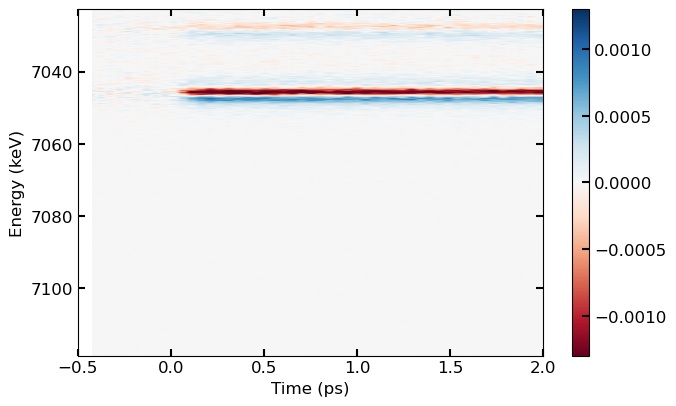

In [8]:
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_spectra(xes_analysis=xes,
                  xes_key='epix_xray_not_laser_time_binned_ROI_1',
                  xes_laser_key='epix_simultaneous_laser_time_binned_ROI_1')
v.vmin=-0.0013
v.vmax=0.0013
v.plot_2d_difference_spectrum(xes)
plt.xlim(-0.5,2.0)

## Averaging all laser off
If the sample is not damaging/changing over the course of the measurement the laser off spectrum should be identical and the S/N can be improved by averaging all laser off data. 

First, let's check the laser off spectrum is not changing using `laser_off_check` which takes the XES analysis object, a data key (laser off in this case), a list of indices to plot and plot x_lims.

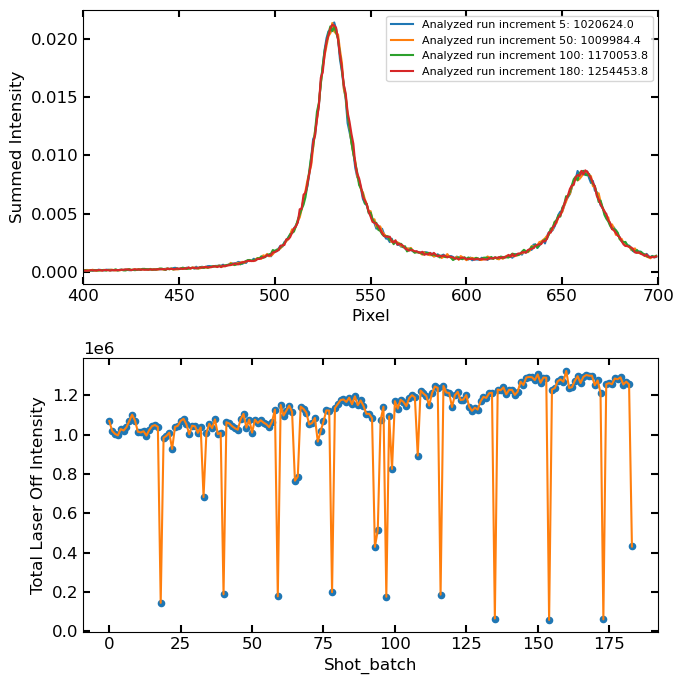

In [9]:
v = XSpect.XSpect_Visualization.XESVisualization()
# Pass XES analysis object from above
v.laser_off_check(xes, 'epix_xray_not_laser_time_binned_ROI_1', 
                    indices_to_plot = [5, 50, 100, 180], x_lims = [400,700])

The `laser_off_check` also creates the `all_runs_laser_off_normalized` attribute for the `xes` analysis object. This 2D array of runs and laser off spectra can be analyzed with SVD to confirm there are no changes in the laser off spectrum across the data collection for the various runs. 

In [10]:
post_processing = XSpect.XSpect_PostProcessing.post_analysis()

In [11]:
# Remove any nans
off = np.nan_to_num(xes.all_runs_laser_off_normalized)
# set x and y axis
runs = np.arange(len(xes.all_runs_laser_off_normalized[:,0]))+1
pixels = np.arange(len(xes.all_runs_laser_off_normalized[0,:]))+1

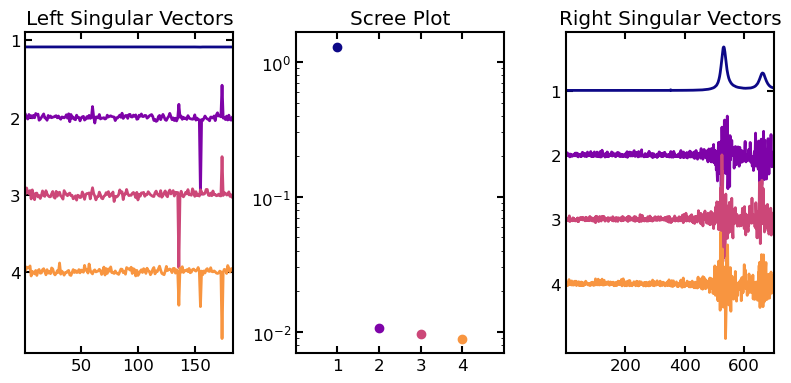

In [12]:
n = 4
colors = plt.cm.plasma(np.linspace(0,1,n+1))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
post_processing.svdplot(runs, pixels, off*-1, n)
plt.tight_layout()

## Comparing S/N of standard analysis and all laser off averaging

Set the `sub_mode` to average all laser off and rerun analysis:

in sub mode


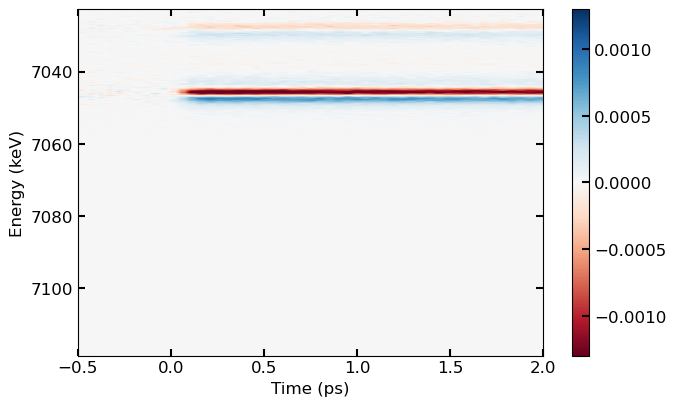

In [28]:
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_spectra(xes_analysis=xes,
                  xes_key='epix_xray_not_laser_time_binned_ROI_1',
                  xes_laser_key='epix_simultaneous_laser_time_binned_ROI_1',
                  sub_mode="avg_all_laser_off")
v.vmin=-0.0013
v.vmax=0.0013
v.plot_2d_difference_spectrum(xes)
plt.xlim(-0.5,2.0)

diff_improved = xes.difference_spectrum

Comparing to the original analysis, the noise is improved a significant amount.

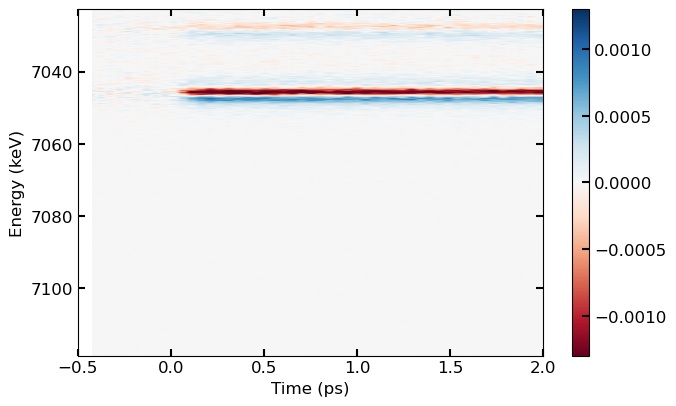

In [29]:
delattr(xes, 'summed_all_laser_off_normalized')
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_spectra(xes_analysis=xes,
                  xes_key='epix_xray_not_laser_time_binned_ROI_1',
                  xes_laser_key='epix_simultaneous_laser_time_binned_ROI_1')
v.vmin=-0.0013
v.vmax=0.0013
v.plot_2d_difference_spectrum(xes)
plt.xlim(-0.5,2.0)

diff_original = xes.difference_spectrum

Plotting 1D slices of the 2D map shows a several factor improvement in S/N (colored spectra are averagin all laser off spectra).

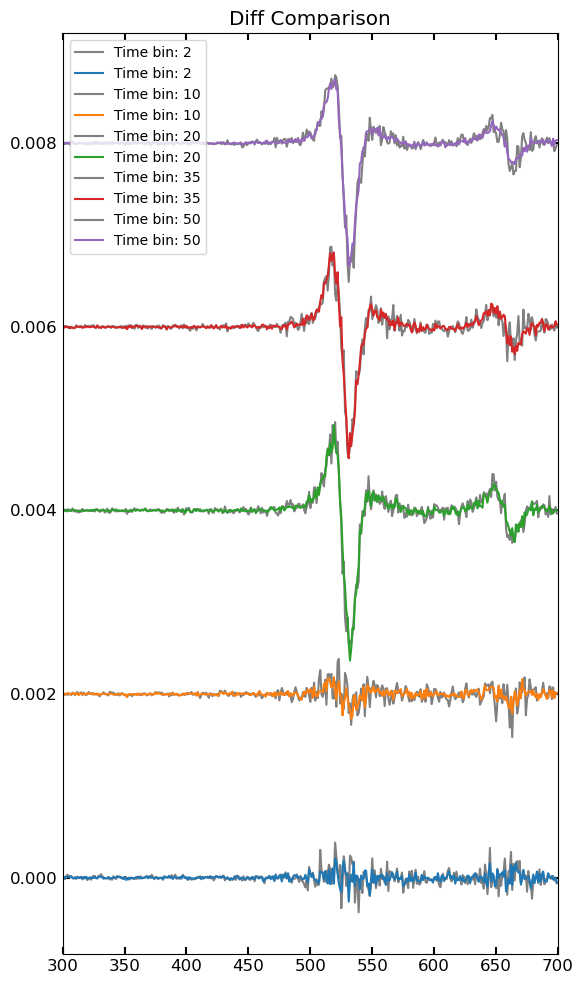

In [30]:
plt.figure(figsize=(6,10))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

indices = [2, 10, 20, 35, 50]

y = 0
for x in indices:
    plt.plot(np.arange(len(diff_original[x,:])), diff_original[x,:] + y, label = "Time bin: " + str(x), color = 'grey')
    plt.legend(loc="upper left")
    plt.title("Diff")
    plt.plot(np.arange(len(diff_improved[x,:])), diff_improved[x,:]+y, label = "Time bin: " + str(x))
    plt.legend(loc="upper left", fontsize=10)
    plt.title("Diff Comparison")
    plt.xlim(300,700)
    y += 0.002
plt.tight_layout()

## Fixed/Improved Image Rotation in Diagnostics

In [3]:
diagnostics = XSpect.XSpect_Diagnostics

In [4]:
run = 40
exp = 'xcs100861524'
keys=['epics/ccm_E','epicsUser/ccm_E_setpoint','tt/ttCorr','epics/lxt_ttc', 'enc/lasDelay', 'ipm4/sum','tt/AMPL', 'epix_2/ROI_0_area'] 
names=['ccm','ccm_E_setpoint','time_tool_correction','lxt_ttc','encoder','ipm', 'time_tool_ampl', 'epix']
d = diagnostics.diagnostics(run, exp, keys, names)

Run 40 imported


A third subplot that sums along the y-axis for a given ROI has been added. Helpful for rotating images when crystal alignment is slightly askew.

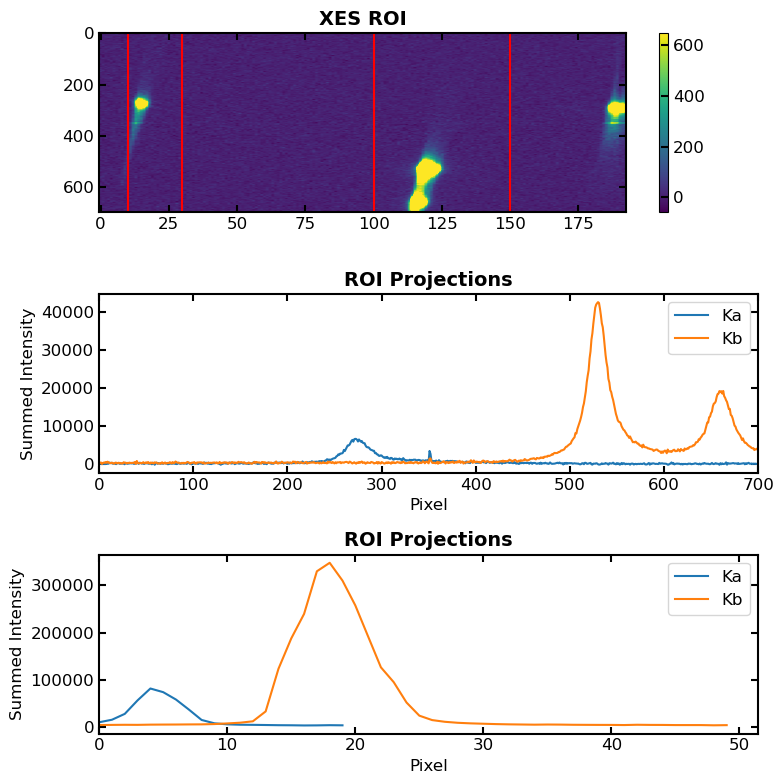

In [6]:
# No rotation
d.xes_ROI(1000, [100,150],[10,30])

Rotating image by 1.4 degree(s)


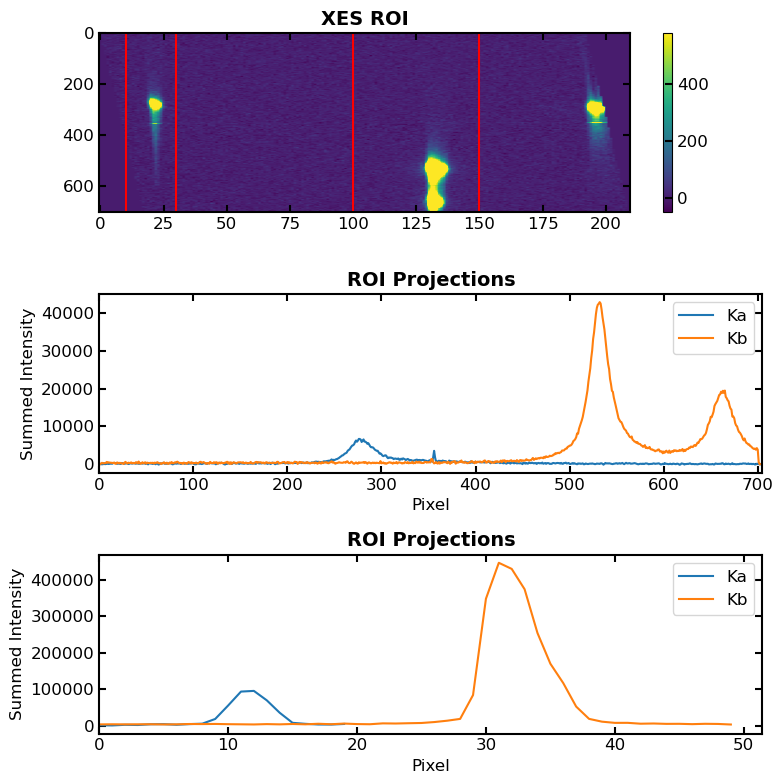

In [7]:
# Rotation
d.xes_ROI(1000, [100,150],[10,30], angle = 1.4)